In [2]:
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

C:\Users\Robak\AppData\Local\Temp/ipykernel_10000/1074351551.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Przygotowanie danych

In [4]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root="data/", train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root="data/", train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(10,10+num)], dim=0)

Files already downloaded and verified
Files already downloaded and verified


# Budowanie autoenkodera
Generalnie autoenkoder zbudowany jest z enkodera który mapuje wejściowe obrazki **x** w niskowymiarową przestrzeń ukrytą **z** oraz dekodera który odwraca tę operację i rekonstruuje wejście **x** z przestrzeni ukrytej **z**

Przykład w oparciu o https://uvadlc-notebooks.readthedocs.io/en/latest/index.html

Zacznijmy od stworzenia enkodera

In [5]:
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

### Uwaga
Zauważmy, że w enkoderze nie ma ani dropoutu, ani BatchNormalization, ani Poolingu dlaczego?

### Dekoder
Dekoder jest lustrzanym odbiciem enkodera, w związku z tym musimy zastosować operację odwrotną do konwolucji, jak mogłaby ona wyglądać?

In [6]:
conv_t = nn.ConvTranspose2d(1,1,kernel_size=2,bias=False)

In [7]:
torch.ones([1,1,3,3])

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [8]:
conv_t.weight

Parameter containing:
tensor([[[[-0.1869,  0.0374],
          [ 0.2784,  0.0706]]]], requires_grad=True)

In [9]:
conv_t(torch.ones([1,1,3,3]))

tensor([[[[-0.1869, -0.1495, -0.1495,  0.0374],
          [ 0.0915,  0.1996,  0.1996,  0.1081],
          [ 0.0915,  0.1996,  0.1996,  0.1081],
          [ 0.2784,  0.3491,  0.3491,  0.0706]]]],
       grad_fn=<SlowConvTranspose2DBackward0>)

In [10]:
conv_t = nn.ConvTranspose2d(1,1,kernel_size=2,bias=False, output_padding=1,padding=1,stride=2)
conv_t(torch.ones([1,1,3,3]))

tensor([[[[-0.3926,  0.2687, -0.3926,  0.2687, -0.3926],
          [ 0.4392,  0.0478,  0.4392,  0.0478,  0.4392],
          [-0.3926,  0.2687, -0.3926,  0.2687, -0.3926],
          [ 0.4392,  0.0478,  0.4392,  0.0478,  0.4392],
          [-0.3926,  0.2687, -0.3926,  0.2687, -0.3926]]]],
       grad_fn=<SlowConvTranspose2DBackward0>)

In [11]:
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

## Połączmy enkoder z dekoderem

In [12]:
class Autoencoder(nn.Module):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3, 
                 width: int = 32, 
                 height: int = 32):
        super().__init__()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

## Trenowanie modelu 
Jako funkcję straty wykorzystamy MSE pomiędzy oryginalnymi, a rekonstruowanymi pikselami. Jakie może to powodować problemy?

c:\users\robak\desktop\ssne\8 - autoenkodery\venv\lib\site-packages\torchvision\utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


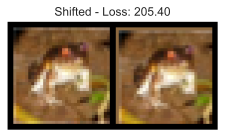

c:\users\robak\desktop\ssne\8 - autoenkodery\venv\lib\site-packages\torchvision\utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


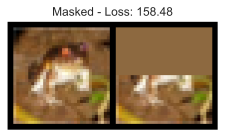

c:\users\robak\desktop\ssne\8 - autoenkodery\venv\lib\site-packages\torchvision\utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


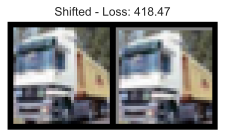

c:\users\robak\desktop\ssne\8 - autoenkodery\venv\lib\site-packages\torchvision\utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


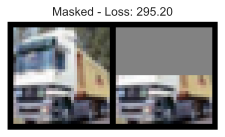

In [15]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")
    # Plot images for visual comparison
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(dim=[1,2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

## Inne funkcje straty dla autoenkoderów:
- Adwersarialna funkcja straty (na następnych zajęciach)
- Funkcje straty w oparciu o transformaty (np. Laplacian piramid loss)

In [16]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=128, encoder_class=Encoder, decoder_class=Decoder).to(device)

In [17]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 100
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out = autoencoder(x)
        loss = criterion(out, x) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
    if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out = autoencoder(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 10 loss 21341.589330357143, test L1 = 0.11501521784812212
Epoch 11 loss 20504.522042410714, test L1 = 0.11315580513328313
Epoch 12 loss 19736.34435267857, test L1 = 0.11103742122650147
Epoch 13 loss 18948.56082589286, test L1 = 0.1081793524324894
Epoch 14 loss 18230.59010044643, test L1 = 0.10670335553586482
Epoch 15 loss 17787.904720982144, test L1 = 0.10498500373214484
Epoch 16 loss 17326.174754464286, test L1 = 0.10520192794501781
Epoch 17 loss 16920.30720424107, test L1 = 0.10238796174526214
Epoch 18 loss 16515.075691964284, test L1 = 0.10120435245335102
Epoch 19 loss 16295.938850446428, test L1 = 0.10048694312572479
Epoch 20 loss 15809.308342633929, test L1 = 0.09952878281474113
Epoch 21 loss 15640.101194196428, test L1 = 0.0986157463863492
Epoch 22 loss 15397.72568080357, test L1 = 0.0989615773782134
Epoch 23 loss 15193.119994419643, test L1 = 0.09718717020004988
Epoch 24 loss 15066.712606026786, test L1 = 0.09848927110433578
Epoch 25 loss 14825.617488839285, test L1 = 0.09

KeyboardInterrupt: 

In [ ]:
# torch.save(autoencoder.state_dict(),"lab_8/autoencoder_128")

In [ ]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=128, encoder_class=Encoder, decoder_class=Decoder).to(device)
autoencoder.load_state_dict(torch.load("lab_8/autoencoder_128"))

In [ ]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
input_imgs = get_train_images(8)
visualize_reconstructions(autoencoder, input_imgs, device)

# Większa przestrzeń ukryta

In [ ]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=256, encoder_class=Encoder, decoder_class=Decoder).to(device)

In [ ]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 100
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out = autoencoder(x)
        loss = criterion(out, x) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out = autoencoder(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

In [ ]:
# torch.save(autoencoder.state_dict(),"lab_8/autoencoder_256")

In [ ]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=256, encoder_class=Encoder, decoder_class=Decoder).to(device)
autoencoder.load_state_dict(torch.load("lab_8/autoencoder_256"))

In [ ]:
input_imgs = get_train_images(8)
visualize_reconstructions(autoencoder, input_imgs, device)

In [ ]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=512, encoder_class=Encoder, decoder_class=Decoder).to(device)

In [ ]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 100
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out = autoencoder(x)
        loss = criterion(out, x) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out = autoencoder(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

In [ ]:
# torch.save(autoencoder.state_dict(),"lab_8/autoencoder_512")

In [ ]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=512, encoder_class=Encoder, decoder_class=Decoder).to(device)
autoencoder.load_state_dict(torch.load("lab_8/autoencoder_512"))

In [ ]:
input_imgs = get_train_images(8)
visualize_reconstructions(autoencoder, input_imgs, device)

In [ ]:
input_imgs = get_train_images(8)
for latent in [128,256,512]:
    autoencoder = Autoencoder(base_channel_size=32, latent_dim=latent, encoder_class=Encoder, decoder_class=Decoder).to(device)
    autoencoder.load_state_dict(torch.load(f"lab_8/autoencoder_{latent}"))
    visualize_reconstructions(autoencoder, input_imgs, device)

In [ ]:
latent = 256
autoencoder = Autoencoder(base_channel_size=32, latent_dim=latent, encoder_class=Encoder, decoder_class=Decoder).to(device)
autoencoder.load_state_dict(torch.load(f"lab_8/autoencoder_{latent}"))

# Czy jesteśmy w stanie wszystko zrekonstruować z podobną skutecznością?

In [ ]:
rand_imgs = torch.rand(4, 3, 32, 32) * 2 - 1
visualize_reconstructions(autoencoder, rand_imgs, device)

In [ ]:
plain_imgs = torch.zeros(4, 3, 32, 32)

# Single color channel
plain_imgs[1,0] = 1 
# Checkboard pattern
plain_imgs[2,:,:16,:16] = 1
plain_imgs[2,:,16:,16:] = -1
# Color progression
xx, yy = torch.meshgrid(torch.linspace(-1,1,32), torch.linspace(-1,1,32))
plain_imgs[3,0,:,:] = xx
plain_imgs[3,1,:,:] = yy

visualize_reconstructions(autoencoder, plain_imgs, device)

# Generowanie nowych obrazków
Skoro mamy reprezentacje ukryte, to możemy wylosować dowolny wektor i odtworzyć nowy obrazek?

In [ ]:
latent_vectors = torch.randn(8, latent, device=device)
with torch.no_grad():
    imgs = autoencoder.decoder(latent_vectors)
    imgs = imgs.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()


### Jak to poprawić?

# Przestrzeń ukryta autoenkodera

In [ ]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            z = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(z)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))

train_img_embeds = embed_imgs(autoencoder, train_loader)
test_img_embeds = embed_imgs(autoencoder, test_loader)

In [ ]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    dist = torch.cdist(query_z[None,:], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    # Plot K closest images
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)

## Wizualizacja przestrzeni ukrytej

In [ ]:
import umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
umap = umap.UMAP(metric="cosine", n_neighbors=100)

In [ ]:
train_embedded = umap.fit_transform(train_img_embeds[1][:5000].cpu())

In [ ]:
data = pd.DataFrame(train_embedded)

In [ ]:
data["label"] = train_img_embeds[2][:5000].cpu().numpy()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
# ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.9
)

In [ ]:
examples = []
examples_locations = []
for i in np.random.randint(0,5000,40):
    examples.append(train_img_embeds[0][i].cpu().numpy())
    examples_locations.append(data.iloc[i])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
# ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.1
)
for location, example in zip(examples_locations, examples):
    x, y = location[0], location[1]
    label = int(location["label"])
    ab = AnnotationBbox(OffsetImage(np.swapaxes(np.swapaxes(example,0,1),1,2)/2+0.5, zoom=1), (x, y), frameon=True,
                        bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
    ax.add_artist(ab)
plt.show()

# Wykrywanie nietypowych obrazków w oparciu o reprezentacje

In [ ]:
dist = torch.cdist(train_img_embeds[1], train_img_embeds[1], p=2)

In [ ]:
outliers = torch.sort(dist.sum(0))[1][-5:]
imgs_to_display = train_img_embeds[0][outliers]
grid = torchvision.utils.make_grid(imgs_to_display, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12,3))
plt.axis('off')
plt.imshow(grid)

In [ ]:
most_usual = torch.sort(dist.sum(0))[1][:5]
imgs_to_display = train_img_embeds[0][most_usual]
grid = torchvision.utils.make_grid(imgs_to_display, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12,3))
plt.axis('off')
plt.imshow(grid)

# Odszumianie za pomocą autoenkodera

In [22]:
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_test_data = torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

1.9%Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001EF7E7E54C0>
Traceback (most recent call last):
  File "c:\users\robak\desktop\ssne\8 - autoenkodery\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "c:\users\robak\desktop\ssne\8 - autoenkodery\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
2.5%

31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

92.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



112.7%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [23]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

In [24]:
images_with_noise = mnist_test_data.data.float() + torch.randn_like(mnist_test_data.data.float())*0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


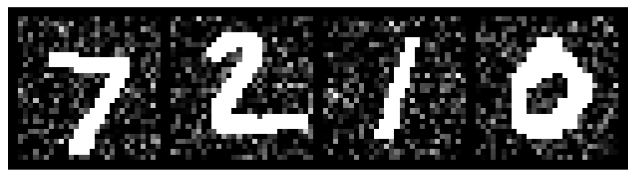

In [25]:
grid = torchvision.utils.make_grid(images_with_noise[:4].unsqueeze(1))#, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12,3))
plt.axis('off')
plt.imshow(grid)

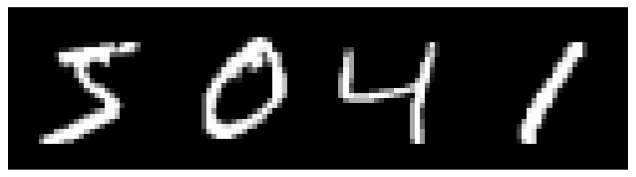

In [26]:
grid = torchvision.utils.make_grid(mnist_data.data[:4].unsqueeze(1))#, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12,3))
plt.axis('off')
plt.imshow(grid)

In [27]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))
        return x
net = Autoencoder().to(device)
print(net)

Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [28]:
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [29]:
train_loss = []
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data # we do not need the image labels
        img = img.to(device)
        optimizer.zero_grad()
        outputs = net(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch+1, epochs, loss))

Epoch 1 of 10, Train Loss: 0.059
Epoch 2 of 10, Train Loss: 0.038
Epoch 3 of 10, Train Loss: 0.034
Epoch 4 of 10, Train Loss: 0.032
Epoch 5 of 10, Train Loss: 0.031
Epoch 6 of 10, Train Loss: 0.031
Epoch 7 of 10, Train Loss: 0.030
Epoch 8 of 10, Train Loss: 0.030
Epoch 9 of 10, Train Loss: 0.029
Epoch 10 of 10, Train Loss: 0.029


In [30]:
imgs, _ = next(iter(train_loader))

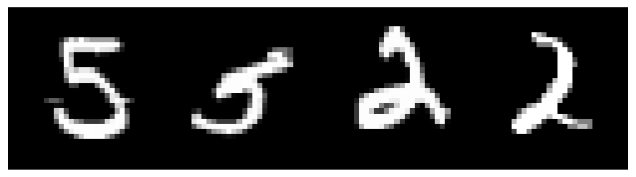

In [31]:
grid = torchvision.utils.make_grid(imgs[:4])#, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12,3))
plt.axis('off')
plt.imshow(grid)

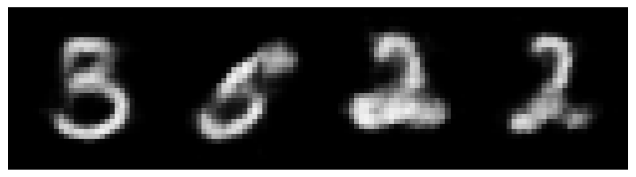

In [32]:
with torch.no_grad():
    examples = net(imgs[:4].to(device)).cpu()
    grid = torchvision.utils.make_grid(examples)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.axis('off')
    plt.imshow(grid)

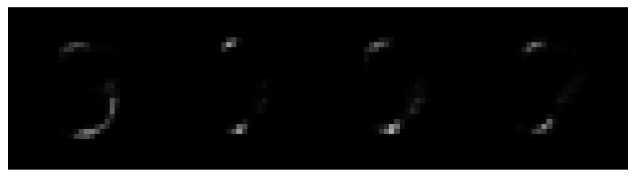

In [33]:
with torch.no_grad():
    examples = net((imgs[:4]+ torch.randn_like(imgs[:4])*0.5).to(device)).cpu()
    grid = torchvision.utils.make_grid(examples)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.axis('off')
    plt.imshow(grid)

### Czy możemy to jeszcze jakoś poprawić?

# Spróbujmy zrobić autoenkoder prostujący obrazki (o ile tego wymagają)
Np. zniekształćmy - przerzućmy część obrazków za pomocą torch.transpose

In [ ]:
grid = torchvision.utils.make_grid(torch.transpose(imgs[10:18],2,3))#, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12,3))
plt.axis('off')
plt.imshow(grid)